In [1]:
## Plots gerais com mapeamento

In [3]:
# -*- coding: utf-8 -*-
import sys
sys.path.append('./libs')

import os
os.environ["PROJ_LIB"] = r"~/anaconda3/lib/site-packages"

import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")

from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon
from matplotlib import cm
from datetime import date
from netCDF4 import Dataset, MFDataset

plt.rcParams.update({'font.size': 22})

%matplotlib inline

In [4]:
def get_rand_color():
    cor = [random.randrange(0, 90)/100, random.randrange(0, 60)/100, random.randrange(0, 90)/100]
    return cor

## Trackings Visualization

In [11]:
EXP= r'./'

# WEDDELL
lat_s = -78
lat_n = -60
lon_w = -65
lon_e = -20

# ROSS
#lat_s = -79
#lat_n = -65
#lon_w = -190
#lon_e = -147

bounds_map = [lat_s, lat_n, lon_w, lon_e]

In [12]:
def draw_screen_poly(lats, lons, m):
    x, y = m(lons, lats)
    xy = list(zip(x, y))
    poly = Polygon(xy, color='r', alpha = 0.8)
    plt.gca().add_patch(poly)

In [13]:
def set_mini_map(m, x, bounds_map):
    
    #min_lat, max_lat = min(m.boundarylats), max(m.boundarylats)
    #min_lon, max_lon = min(m.boundarylons)+25, max(m.boundarylons)
    min_lat, max_lat = bounds_map[0], bounds_map[1]
    min_lon, max_lon = bounds_map[2], bounds_map[3]+10.
    
    # Global map inset
    m.ax = ax
    axin = inset_axes(m.ax, width="20%", height="20%", loc=1)
    inmap = Basemap(projection='spstere', boundinglat=-62, lat_0=-90, lat_ts=-71, lon_0=-180, resolution='l', ax=axin, anchor='NE')
    
    inmap.drawcoastlines()
    inmap.fillcontinents(color='peachpuff')

    lats = [max_lat, min_lat, min_lat, max_lat]
    lons = [min_lon, min_lon, max_lon, max_lon]

    draw_screen_poly(lats, lons, inmap)

In [14]:
def polar_stere(lon_w, lon_e, lat_s, lat_n, **kwargs):
    '''Returns a Basemap object (NPS/SPS) focused in a region.
    lon_w, lon_e, lat_s, lat_n -- Graphic limits in geographical coordinates.
                                  W and S directions are negative.
    **kwargs -- Aditional arguments for Basemap object.
    '''

    # lat_0=-75, lat_ts=-71, lon_0=-45,

    lon_0 = lon_w + (lon_e - lon_w) / 2.
    ref = lat_s if abs(lat_s) > abs(lat_n) else lat_n
    lat_0 = np.copysign(90., ref)
    proj = 'npstere' if lat_0 > 0 else 'spstere'
    prj = Basemap(projection=proj, lon_0=lon_0, lat_0=lat_0,boundinglat=0, resolution='c')
    lons = [lon_w, lon_e, lon_w, lon_e, lon_0, lon_0]
    lats = [lat_s, lat_s, lat_n, lat_n, lat_s, lat_n]
    x, y = prj(lons, lats)
    ll_lon, ll_lat = prj(min(x), min(y), inverse=True)
    ur_lon, ur_lat = prj(max(x), max(y), inverse=True)
    return Basemap(projection='stere', lat_0=lat_0, lon_0=lon_0,
                           llcrnrlon=ll_lon, llcrnrlat=ll_lat,
                           urcrnrlon=ur_lon, urcrnrlat=ur_lat, **kwargs)

In [15]:
def get_base_map(lat_s, lat_n, lon_w, lon_e):
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    m = polar_stere(lon_w, lon_e, lat_s, lat_n)
    m.drawmapboundary(fill_color='white')
    
    fl = Dataset('./Batimetria/topo1.nc')
    lon_start = np.asarray(fl.variables['longitude'])
    lat_start = np.asarray(fl.variables['latitude'])
    inputfield = np.asarray(fl.variables['topo'])
    
    z_min = -6000.
    z_max = 0.
    XX, YY = np.meshgrid(lon_start,lat_start)
    lon_map,lat_map=m(XX[:,:],YY[:,:])
    batimetry = m.contourf(lon_map, lat_map, inputfield, vmin=z_min, vmax=z_max)
    
    path_shp = './LandMask/antarticamask'
    m.readshapefile(path_shp, 'antarticamask')

    patches = []
    for info, shape in zip(m.antarticamask_info, m.antarticamask):
        patches.append(Polygon(np.array(shape), True))

    ax.add_collection(PatchCollection(patches, facecolor='peachpuff', edgecolor='k', linewidths=1., zorder=2))
    
    path_shp = './LandMask/shelves/ne_10m_antarctic_ice_shelves_polys'
    m.readshapefile(path_shp, 'ne_10m_antarctic_ice_shelves_polys')

    patches = []
    for info, shape in zip(m.ne_10m_antarctic_ice_shelves_polys_info, m.ne_10m_antarctic_ice_shelves_polys):
        patches.append(Polygon(np.array(shape), True))

    ax.add_collection(PatchCollection(patches, facecolor='lightskyblue', edgecolor='k', linewidths=1., zorder=2))
    
    sea_ice_path = r'./Sea_Ice/mygeodata2007/extent_S_200702_polygon_v3'
    m.readshapefile(sea_ice_path, 'extent_S_200702_polygon_v3', linewidth=1, color='k')
    
    m.drawparallels(np.arange(-90., 90, 3), labels=[1, 1, 0, 0], linewidth=0.2, rotation=45)
    m.drawmeridians(np.arange(-180., 180., 10), labels=[0, 0, 0, 1], linewidth=0.2, rotation=45)
    
    plt.xlabel('Longitude', labelpad=40, fontsize=16)
    plt.ylabel('Latitude', labelpad=40, fontsize=16)
    
    #cbar = plt.colorbar(batimetry, boundaries=np.arange(0, 3.1, .5))
    #cbar.set_label('meters')
    
    c = plt.cm.ScalarMappable()
    c.set_array(inputfield)
    c.set_clim(z_min, z_max)
    cbar = plt.colorbar(c)
    cbar.set_label('meters')
     
    return m, ax

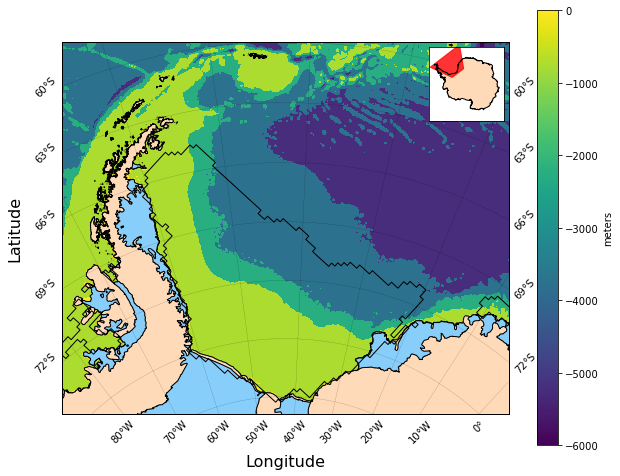

In [16]:
m, ax = get_base_map(lat_s, lat_n, lon_w, lon_e)
set_mini_map(m, ax, [lat_s, lat_n, lon_w, lon_e]) # ROSS lon_w-10

#plt.savefig(EXP+'saidas/'+'ross.jpg', dpi = 300)